# Benchmark Synthetic Dataset Example

This notebook demonstrates using the TimeSeries Agent for a benchmark synthetic dataset, showing:

1. Working with synthetic data
2. Training an RL agent for directional prediction (Up/Down/Same)
3. Evaluating the agent's performance

In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from timeseries_agent.api import train_from_csv
import warnings
warnings.filterwarnings("ignore")

## 1. Get Synthetic Data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/datasets/global-temp/main/data/monthly.csv")
df = df[df['Source'] == 'gcag']
df = df[['Year', 'Mean']]
df['temperature'] = df['Mean']
df.drop(columns=['Mean'], inplace=True)
print(df.shape)
display(df.head())

(2095, 2)


,Year,temperature
0,1850-01,-0.6746
1,1850-02,-0.3334
2,1850-03,-0.5913
3,1850-04,-0.5887
4,1850-05,-0.5088


In [3]:
target_column = 'temperature'
df = df.head(1000)  # Limit to the first 1000 rows for training
last_n_test_rows = 100 # Number of rows to keep for testing

# Split the data into training and testing sets
train_data = df.iloc[:-last_n_test_rows]
test_data = df.tail(last_n_test_rows)

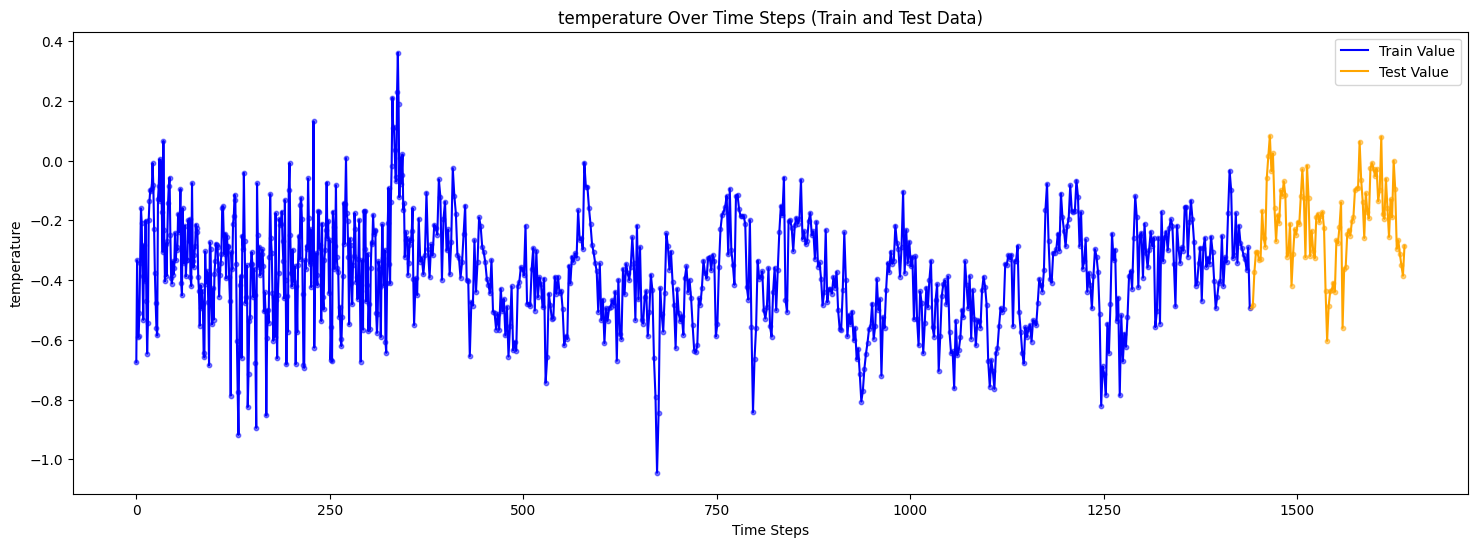

In [4]:
# Plot the training and testing data
plt.figure(figsize=(18, 6))
plt.plot(train_data.index, train_data[target_column], color='blue', label='Train Value')
plt.plot(test_data.index, test_data[target_column], color='orange', label='Test Value')
plt.scatter(train_data.index, train_data[target_column], color='blue', s=10, alpha=0.5)
plt.scatter(test_data.index, test_data[target_column], color='orange', s=10, alpha=0.5)
plt.xlabel('Time Steps')
plt.ylabel(target_column)
plt.title(f"{target_column} Over Time Steps (Train and Test Data)")
plt.legend()
plt.show()

In [5]:
# Compute distribution of directions
train_target_diff = train_data[target_column].diff()
train_directions = train_target_diff.apply(lambda x: 0 if x > 0 else 1 if x < 0 else 2).iloc[1:]
train_directions_counts = Counter(train_directions)
print("Train Directions Counts:", train_directions_counts)

test_target_diff = test_data[target_column].diff()
test_directions = test_target_diff.apply(lambda x: 0 if x > 0 else 1 if x < 0 else 2).iloc[1:]
test_directions_counts = Counter(test_directions)
print("Test Directions Counts:", test_directions_counts)

Train Directions Counts: Counter({1: 459, 0: 439, 2: 1})
Test Directions Counts: Counter({0: 54, 1: 45})


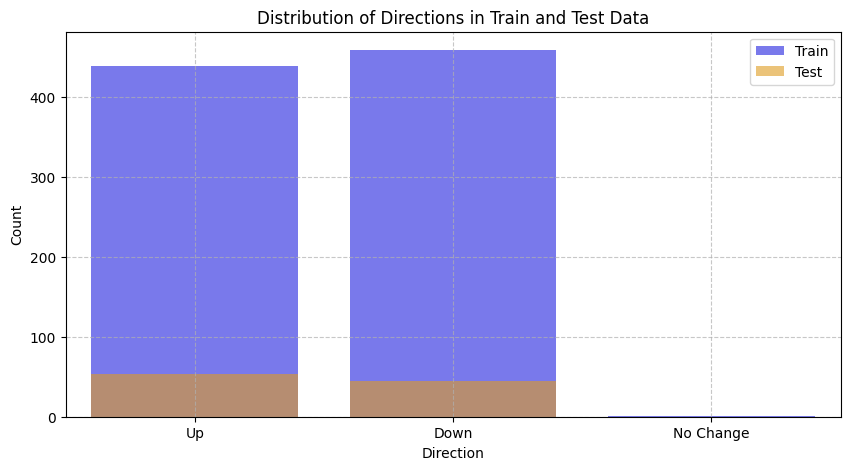

In [6]:
# Create the a bar plot for the distribution of directions
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_directions_counts.keys()), y=list(train_directions_counts.values()), color='blue', alpha=0.6, label='Train')
sns.barplot(x=list(test_directions_counts.keys()), y=list(test_directions_counts.values()), color='orange', alpha=0.6, label='Test')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.title('Distribution of Directions in Train and Test Data')
plt.xticks([0, 1, 2], ['Up', 'Down', 'No Change'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

 ## 2. Feature Engineering

In [7]:
# Extract lags from the target column
train_data['Lag1'] = train_data[target_column].shift(1)
train_data['Lag2'] = train_data[target_column].shift(2)
test_data['Lag1'] = test_data[target_column].shift(1)
test_data['Lag2'] = test_data[target_column].shift(2)

# Drop rows with NaN values after shifting
train_data = train_data.dropna(subset=['Lag1', 'Lag2'])
test_data = test_data.dropna(subset=['Lag1', 'Lag2'])

print(f"Train Shape: {train_data.shape}, Test Shape: {test_data.shape}")
display(train_data.head())

Train Shape: (898, 4), Test Shape: (98, 4)


,Year,temperature,Lag1,Lag2
2,1850-03,-0.5913,-0.3334,-0.6746
3,1850-04,-0.5887,-0.5913,-0.3334
4,1850-05,-0.5088,-0.5887,-0.5913
5,1850-06,-0.3442,-0.5088,-0.5887
6,1850-07,-0.1598,-0.3442,-0.5088


In [8]:
# Save the training and testing data to CSV files
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
train_csv_path = os.path.join(DATA_DIR, 'global_temp_train.csv')
test_csv_path = os.path.join(DATA_DIR, 'global_temp_test.csv')

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

## 3. Train Agent

In [9]:
# Define feature columns and target column. Note: Target column can also be used as a feature
feature_cols = ['Lag1', 'Lag2']  + [target_column]  
target_col= target_column 

# Define environment kwargs
lookback = 10                                           # Number of previous time steps to consider  
env_kwargs = {
        'lookback': lookback,
        'normalize_state': True,
        'test_size': 0.2                                # Use 20% of data for validation
    }

# Define agent kwargs 
agent_type = 'reinforce_step'                           # options: 'ppo', 'reinforce', and 'reinforce_step'
agent_kwargs = {
        'hidden_layers': [100, 100, 10],                # More complex architecture for better learning
        'output_size': 3,                               # Three possible actions: Up, Down, Same
        'agent_type': agent_type,
    }

# Define trainer kwargs
trainer_kwargs = {
        'max_epochs': 100,                               # Number of epochs for training
        'enable_checkpointing': True,
        'experiment_name': f'pattern_bm_{agent_type}',   # Name of the experiment
    }

# Train with automatic action sampling and reward generation
agent = train_from_csv(
    csv_path=train_csv_path,
    feature_cols=feature_cols,
    target_col=target_col,
    env_kwargs=env_kwargs,
    agent_kwargs=agent_kwargs,
    trainer_kwargs=trainer_kwargs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 14.2 K | train
-----------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.47337278723716736    │
│          val_f1           │    0.47337278723716736    │
│       val_precision       │    0.4734058976173401     │
│        val_recall         │    0.47337278723716736    │
│        val_reward         │   -0.053170204162597656   │
│         val_steps         │           169.0           │
└───────────────────────────┴───────────────────────────┘

### 3. a. Plot Training Logs

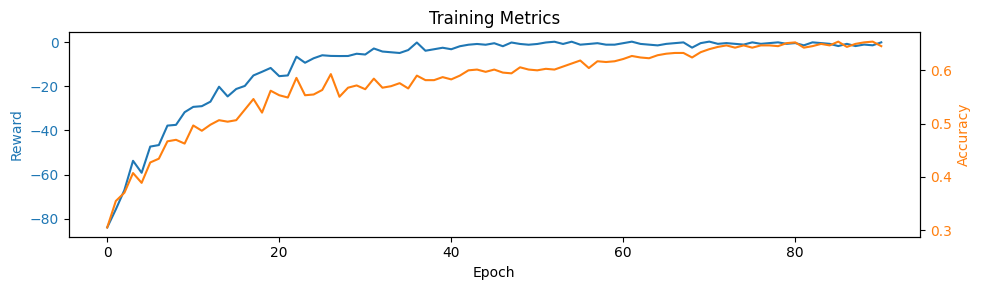

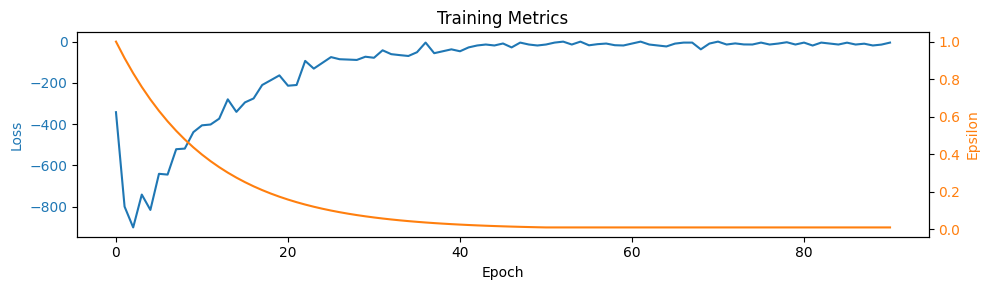

In [10]:
from timeseries_agent.utils.extras import plot_training_metrics
plot_training_metrics(agent)

## 4. Evaluate Agent

The agent predicts the direction of the sequence (Up/Down/Same) based on recent data

In [11]:
from timeseries_agent.api import load_agent

In [12]:
log_dir = agent.trainer.logger.log_dir
checkpoint_path = os.path.join(log_dir, 'checkpoints', 'last.ckpt')
print(checkpoint_path)

logs\pattern_bm_reinforce_step\version_0\checkpoints\last.ckpt


In [13]:
# Load the trained agent
loaded_agent = load_agent(
    checkpoint_path=checkpoint_path,
    csv_path=test_csv_path,
    feature_cols=feature_cols,
    target_col=target_col,
    agent_type=agent_type,                  # Specify the agent type
    **env_kwargs                            # Pass the same environment configuration used during training
)

In [14]:
# 0: Up, 1: Down, 2: Same
def get_true_action(current_val, next_val):
    true_action = 0 if next_val > current_val else 1 if next_val < current_val else 2
    return true_action

# Batch predictions on historical data
def get_batch_predictions(df, lookback_size):
    predictions = []
    true_actions = []
    for i in range(lookback_size, len(df)):
        if i >= len(df) - 1:
            continue
        current_features = df[feature_cols].iloc[i-lookback_size:i].values.astype(np.float32)
        current_target = df[target_col].iloc[i]
        pred_action, probs = loaded_agent.act(current_features, return_probs=True)
        predictions.append(pred_action)
        next_target = df[target_col].iloc[i+1]
        true_action = get_true_action(current_target, next_target)
        print(f'True={true_action} -- Pred={pred_action} -- Probs={probs}')
        true_actions.append(true_action)
        
    return true_actions, predictions

# Load the test data and get predictions
df = pd.read_csv(test_csv_path)

lookback_size = lookback
y_true, y_pred = get_batch_predictions(df[:], lookback_size)

print(f'\n true dist == {Counter(y_true)}, pred dist == {Counter(y_pred)}')

True=1 -- Pred=1 -- Probs=[6.8348001e-08 9.9999988e-01 6.3031185e-09]
True=0 -- Pred=1 -- Probs=[2.4504551e-08 9.9984694e-01 1.5301559e-04]
True=1 -- Pred=1 -- Probs=[6.6914772e-08 9.9999988e-01 7.4184787e-09]
True=1 -- Pred=1 -- Probs=[5.3774201e-08 1.0000000e+00 4.9708255e-08]
True=0 -- Pred=1 -- Probs=[6.1504664e-08 9.9999988e-01 1.5223764e-08]
True=1 -- Pred=1 -- Probs=[7.467659e-08 9.999999e-01 8.164888e-09]
True=0 -- Pred=0 -- Probs=[1.0000000e+00 1.8560097e-08 1.1877556e-08]
True=1 -- Pred=0 -- Probs=[1.0000000e+00 4.5622343e-08 4.1713868e-09]
True=0 -- Pred=0 -- Probs=[1.0000000e+00 2.1039572e-08 9.9368354e-09]
True=1 -- Pred=0 -- Probs=[1.00000000e+00 1.92826342e-08 1.09006635e-08]
True=1 -- Pred=0 -- Probs=[9.9999988e-01 1.4661055e-07 1.1477146e-09]
True=0 -- Pred=0 -- Probs=[9.9999988e-01 1.4991765e-07 1.1569832e-09]
True=0 -- Pred=1 -- Probs=[7.1075284e-08 9.9999988e-01 4.4275628e-09]
True=1 -- Pred=1 -- Probs=[7.1607055e-08 9.9999988e-01 9.3372501e-09]
True=0 -- Pred=0 -- 

### 4.b. Visualize Agents Evaluation Metrics

In [15]:
from timeseries_agent.utils.extras import (plot_prediction_density, 
                            plot_confusion_matrix_n_metrics, plot_animated_signal_line_chart)

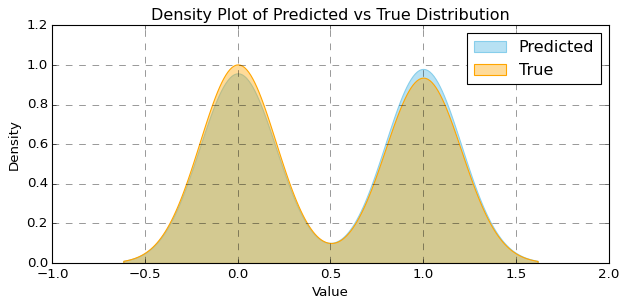

In [20]:
plot_prediction_density(y_true, y_pred,
                        os.path.join(DATA_DIR,'predictions_analysis.png'))

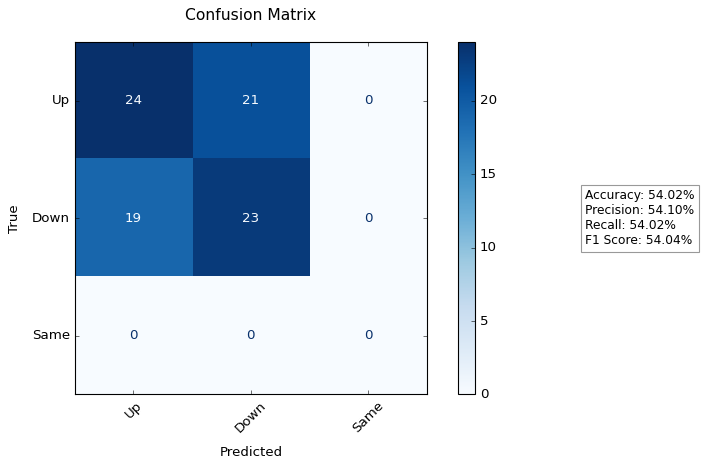

In [17]:
plot_confusion_matrix_n_metrics(y_true, y_pred)

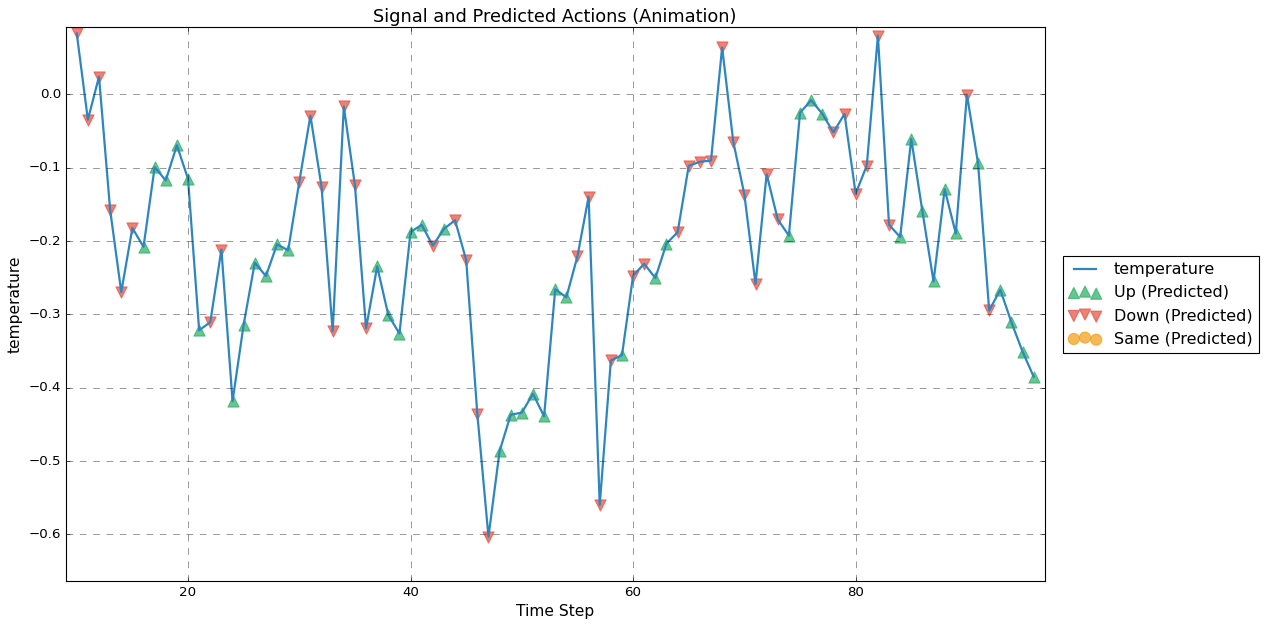

In [18]:
plot_animated_signal_line_chart(df, target_column, y_true, y_pred, lookback,
                                os.path.join(DATA_DIR,'global_temp_predictions_animation.gif'))